## Computer Vision作业

In [1]:
import matplotlib.pyplot as plt # plt 用于显示图片
import cv2 as cv # mpimg 用于读取图片
import numpy as np

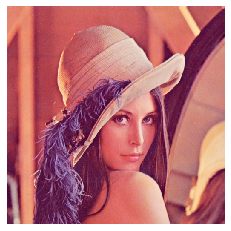

In [2]:
lena = cv.imread('lena.jpg') # 读取和代码处于同一目录下的 lena.png
lena = cv.cvtColor(lena,cv.COLOR_BGR2RGB)
plt.imshow(lena)
plt.axis("off")
plt.show()

### 1、对lena.png做直方图均衡化

In [3]:
# TODO
lena_hsv = cv.cvtColor(lena, cv.COLOR_RGB2HSV)
# Using HSV color space to do Histogram Equalization.

In [20]:
lightness = lena_hsv[:,:,2]
cnt,_ = np.histogram(lightness, bins=256)
from itertools import accumulate
ps = np.array(list(accumulate(cnt)))
ps = ps*255/ps[-1]
p = np.rint(ps).astype(np.int)
lena_hsv[:,:,2] = p[lena_hsv[:,:,2]]
lena_new = cv.cvtColor(lena_hsv,cv.COLOR_HSV2RGB)

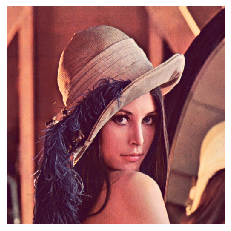

In [21]:
plt.imshow(lena_new)
plt.axis("off")
plt.show()

### 2、基于opencv使用卷积操作对图像做模糊、锐化操作

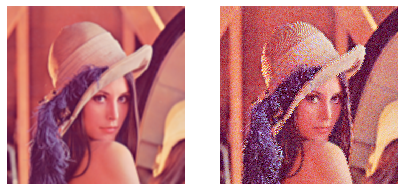

In [6]:
# tips：自定义卷积核，使用cv.filter2D对图像进行卷积操作。调整得到不同卷积核从而得到模糊或锐化的不同效果，如下图示。
# TODO
gk = cv.getGaussianKernel(7,10)
gaussian = gk*gk.T

laplacian1=np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])

laplacian2=np.array([[0, 1, 0],
                    [1, -3, 1],
                    [0, 1, 0]])

laplacian3=np.array([[-1,0,-1],
                    [0, 5, 0],
                    [-1,0,-1]])

laplacian4=np.array([[1, 0, 1],
                    [0, -3, 0],
                    [1, 0, 1]])

ll = 1.3
lk =np.array([[0, ll, 0],
            [ll, 1-ll*4, ll],
            [0, ll, 0]])

blur = cv.filter2D(lena,-1,gaussian)
sharp = cv.filter2D(lena,-1,lk)

fig,axes = plt.subplots(1,2,figsize=(7,4))
axes[0].axis('off')
axes[1].axis('off')
axes[0].imshow(blur)
axes[1].imshow(sharp)
plt.show()


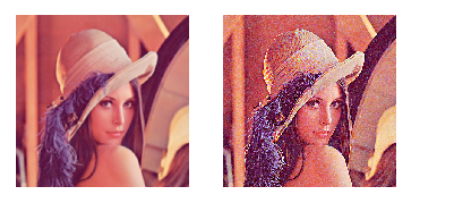

### 3、利用角点检测方法将规则图形旋转摆正

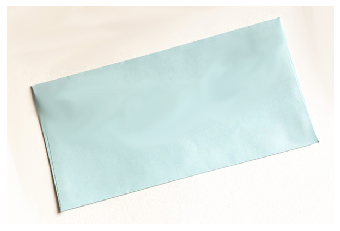

In [113]:
letter = cv.imread('letter.jpg') # 读取和代码处于同一目录下的 letter.jpg
letter = cv.cvtColor(letter,cv.COLOR_BGR2RGB)
plt.imshow(letter)
plt.axis("off")
plt.show()
# 可行思路1：先通过角点检测计算得到四个顶点的位置（默认对象为长方形）然后计算需要旋转的角度，利用仿射变换进行旋转。
# 角点检测算法可用cv2.cornerHarris
# 或可用其他方式达到规则图形摆正的效果即可。
# TODO


In [11]:
import sklearn
from sklearn.cluster import KMeans

In [13]:
gray=cv.cvtColor(letter,cv.COLOR_RGB2GRAY)
dst=cv.cornerHarris(gray,2,3,0.04)
one = dst > 0.01*dst.max()
lst = [(i,j) for i in range(letter.shape[0]) for j in range(letter.shape[1]) if one[i][j]]
kmeans = KMeans(n_clusters=4).fit(lst)


In [128]:
corner = np.rint(kmeans.cluster_centers_).astype(np.int)
corner=np.vstack((corner[:,1],corner[:,0])).transpose()


In [129]:
from itertools import permutations


In [130]:
def dis(A, B):
    return sum(np.sqrt(sum((x-y)**2 for x,y in zip(i,j))) for i,j in zip(A,B))
        

[[ 45. 148.]
 [500.  21.]
 [571. 249.]
 [ 97. 378.]]
[[  0.   0.]
 [599.   0.]
 [599. 399.]
 [  0. 399.]]
45 148
500 21
571 249
97 378


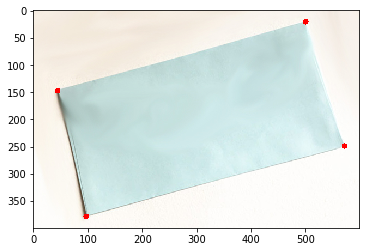

In [434]:
delta = 0
# leave 0 pixel bounder
H,W,_=letter.shape
std = np.array([[delta,delta],[W-1-delta,delta],[W-1-delta,H-1-delta],[delta,H-1-delta]],dtype=np.float32)
pos = np.array(min(((dis(A,std),A) for A in permutations(corner)), key=lambda x:x[0] )[1],dtype=np.float32)
warped = cv.getPerspectiveTransform(src=pos,dst=std)
print(pos)
print(std)
tmp=letter.copy()
for i in pos:
    x=int(i[0])
    y=int(i[1])
    print(x,y)
    tmp=cv.circle(tmp,(x,y),5,(255, 0, 0) ,-1)

plt.imshow(tmp)

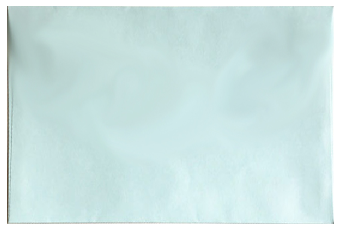

In [435]:
result = cv.warpPerspective(letter, warped, (W,H))
plt.imshow(result)
plt.axis("off")
plt.show()

### 4、对Olivetti人脸数据进行非负矩阵分解(指定特征维度为49)，并画出得到的脸部局部特征，类似于下图
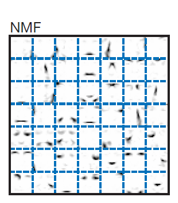
### 按新的49维特征聚类并与PCA降维同样维度下的结果进行对比

In [139]:
# 读取数据
from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces()
faces = dataset.data

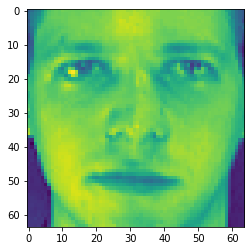

0.08264463 0.87603307


In [373]:
# TODO
img=np.resize(faces[0], (2**6,2**6))
plt.imshow(img)
plt.show()
print(np.min(img),np.max(img))

In [374]:
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA

In [376]:
model = NMF(n_components=49, init='nndsvda', tol=5e-4, max_iter=500)
W = model.fit_transform(faces.transpose())
H = model.components_

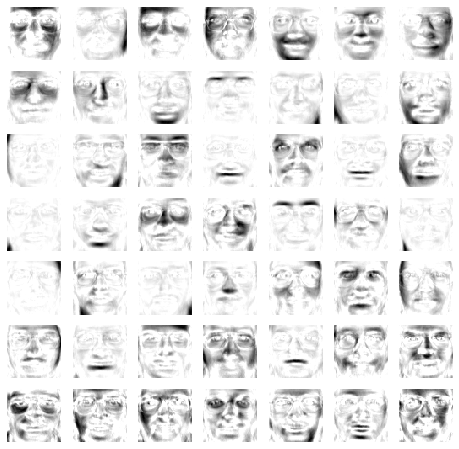

In [401]:
fig,axes = plt.subplots(7,7,figsize=(8,8))
for i in range(7):
    for j in range(7):
        axes[i][j].imshow(np.resize(W[:,i*7+j], (64,64)), cmap='gray_r')
        axes[i][j].axis('off')
plt.show()

In [378]:
pca = PCA(n_components=49)
pW=pca.fit_transform(faces.transpose())

In [379]:
pH=pca.components_

In [380]:
print(pW.shape, pH.shape)

(4096, 49) (49, 400)


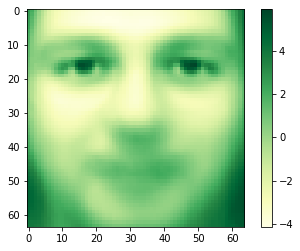

In [437]:
plt.imshow(np.resize(pW[:,0], (64,64)), cmap='YlGn')
plt.colorbar()
plt.show()

In [445]:
#img = np.resize(pW[:,0], (64,64))
#img -= img.min()
#img /= img.max()
#cv.imwrite('pca_face.png', 255-img*255)

True

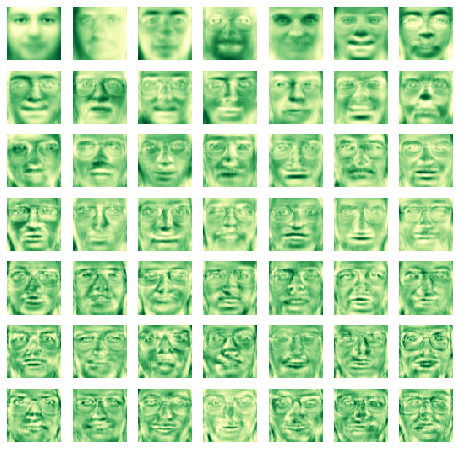

In [429]:
fig,axes = plt.subplots(7,7,figsize=(8,8))
for i in range(7):
    for j in range(7):
        axes[i][j].imshow(np.resize(pW[:,i*7+j], (64,64)), cmap='YlGn')
        axes[i][j].axis('off')
plt.show()

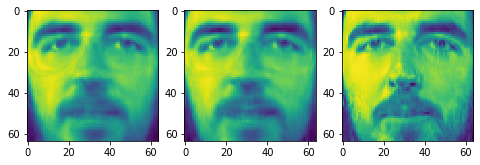

In [430]:
idx=105
fig,axes = plt.subplots(1,3,figsize=(8,8))
axes[0].imshow(np.resize((W@H)[:,idx], (64,64)))
axes[1].imshow(np.resize((pW@pH)[:,idx], (64,64)))
axes[2].imshow(np.resize(np.resize(faces[idx], (2**6,2**6)), (64,64)))
plt.show()

In [431]:
from sklearn.cluster import KMeans
#print(H.transpose()[399])

In [432]:
nmf_pred = KMeans(n_clusters=40, random_state=7).fit_predict(H.transpose())
pca_pred = KMeans(n_clusters=40, random_state=3).fit_predict(pH.transpose())

In [433]:
from sklearn.metrics.cluster import adjusted_rand_score
print(adjusted_rand_score(dataset.target, nmf_pred))
print(adjusted_rand_score(dataset.target, pca_pred))

0.3824324451602573
0.48337965926328613


PCA的分数比NMF的分数略高。